## 7.1 Agentic AI (ReAct) with LangGraph

In this notebook, you will learn how to create and deploy a ReAct (Reasoning + Acting) agent capable of solving complex tasks by combining logical reasoning with external tool usage. The agent will use a structured loop of Thought → Action → Observation to iteratively reason through problems, gather data, and provide solutions.

By the end of this notebook, you will:

* Implement a ReAct agent that breaks down complex user queries into smaller, manageable steps.
* Integrate external tools (e.g., search engines, calculators, etc) that the agent can use to enhance its problem-solving abilities.
* Efficiently handle tool outputs and errors, allowing the agent to adapt its actions based on real-time feedback.

### 1. Agentic AI Overview 

An Agent is an autonomous system that leverages Large Language Models (LLMs) to perform tasks by understanding, reasoning, planning, and executing actions with minimal human intervention. AI agents are designed to break down complex problems into manageable steps, utilizing tools, accessing memory, and adapting their behavior based on the provided context.

At its core, an agent is structured to:

* Receive a Task: The agent takes input from the user, such as a question or command.
* Plan a Solution: The agent decomposes the problem, chooses appropriate tools, and reasons through possible solutions.
* Execute the Plan: It performs actions, such as retrieving information, using tools, or generating responses based on the devised plan.
* Deliver Results: Finally, it presents the solution or output in a structured, actionable format.

![LLM Tools](../../content/modules/ROOT/assets/images/04/04-02-react-diagram.png)

### 2. Agentic AI Framework Used - LangGraph

**LangGraph** is a library designed for creating complex, stateful applications that use large language models (LLMs) to manage agent and multi-agent workflows. Unlike traditional frameworks, LangGraph uses graph-based cycles instead of directed acyclic graphs (DAGs), enabling more intricate and adaptable workflows. This approach supports advanced use cases where agents may revisit tasks or adjust based on dynamic changes.

### 3. Setup and Import Libraries

To get started, you'll need to install and import a few Python libraries. Run the following command to install them:

In [1]:
!pip install -q langchain-openai termcolor langchain_community duckduckgo_search wikipedia openapi-python-client==0.12.3 langgraph langchain_experimental


[notice] A new release of pip available: 22.2.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
# Imports
import os
import json
import getpass

from langchain.chains import ConversationChain
from langchain.memory import ConversationBufferMemory
from langchain.chains import LLMChain
from langchain_openai import ChatOpenAI
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
from langchain.prompts import PromptTemplate
from langchain_core.messages import BaseMessage

from typing_extensions import TypedDict
from typing import Annotated

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL


### 4. Model Configuration

We will start by creating an llm instance, defined by the location where the LLM API can be queried and some parameters that will be applied to the model.


#### 4.1 Define the Inference Model Server specifics

In [3]:
INFERENCE_SERVER_URL = "https://mistral-7b-instruct-v0-3-maas-apicast-production.apps.prod.rhoai.rh-aiservices-bu.com:443"
MODEL_NAME = "mistral-7b-instruct"
API_KEY= os.getenv('API_KEY')

#### 4.2 Create the LLM instance

In [4]:
llm = ChatOpenAI(
    openai_api_key=API_KEY,
    openai_api_base= f"{INFERENCE_SERVER_URL}/v1",
    model_name=MODEL_NAME,
    top_p=0.92,
    temperature=0.01,
    max_tokens=512,
    presence_penalty=1.03,
    streaming=True,
    callbacks=[StreamingStdOutCallbackHandler()]
)

### 5. Define tools

First, we will configure the tool by initializing the DuckDuckGo search functionality. This will be the primary tool for real-time search queries in this example.

On the other hand sometimes, for complex calculations, rather than have an LLM generate the answer directly, it can be better to have the LLM generate code to calculate the answer, and then run that code to get the answer. In order to easily do that, we provide a simple Python REPL to execute commands in.

In [5]:
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

repl = PythonREPL()


@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your calculations."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

from langchain_community.tools import DuckDuckGoSearchRun

# Initialize DuckDuckGo Search Tool
duckduckgo_search = DuckDuckGoSearchRun()

We will define the list of Tools that will be used by our AI Agents 

In [6]:
from langgraph.prebuilt import ToolNode

tools = [duckduckgo_search, python_repl]

We need make sure the model knows that it has these tools available to call. We can do this by converting the LangChain tools into the format for OpenAI tool calling using the .bind_tools() method.

In [7]:
llm_with_tools = llm.bind_tools(tools)

### 6. Creating a ReAct Agent

In this section, we will build a ReAct agent that autonomously reasons through tasks and selects the appropriate tools to solve problems. The agent will follow a structured process to deliver actionable results.

#### 6.1 Architecture Explanation

- **Agent Components**:
  - **Memory**: The agent's memory module stores past interactions and relevant data to inform future decisions.
  - **Planning**: This module breaks down complex tasks into manageable steps, helping the agent decide the sequence of actions.
  - **Tools**: The tools module enables the agent to interact with external systems, such as performing calculations, retrieving data, or running APIs.

- **System Prompt & User Prompt**: 
  - The **System Prompt** provides context and instructions for how the agent should operate within its environment, including the tools available.
  - The **User Prompt** is the input provided by the user, specifying the task or query the agent needs to handle.

- **LLM Interaction**: 
  - The Large Language Model (LLM) is at the core of the agent’s decision-making. It processes both the system and user prompts, and its outputs guide the agent’s actions. The LLM can reason about tasks, plan, and adapt based on external tool outputs.
  
- **External Environments**:
  - The **Local Environment** consists of tools and systems the agent interacts with locally on its workstation.
  - The **External Environment** is any external system or API that the agent can call for additional information or actions.

This architecture allows the ReAct agent to efficiently break down complex tasks, take action, and observe the results in a structured, repeatable process.

![Agent Architecture](../../content/modules/ROOT/assets/images/05/05-03-react-agent-architecture-modules.png)

#### 6.2 Create Agent Graphs

Create the individual agents below and tell them how to talk to each other using LangGraph.

In [8]:
from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    ToolMessage,
    AIMessage,  # Make sure to import AIMessage
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langgraph.graph import END, StateGraph, START

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

#### 6.3 Define Edge Logic

We can define some of the edge logic that is needed to decide what to do based on results of the agents

In [9]:
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [10]:
graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools)
graph_builder.add_node("tools", tool_node)

#### 6.4 Define Tool Node

Defines the logic for the graph. Adds conditional edges for the chatbot to use tools when needed, and ensures the flow returns to the chatbot after tool execution.

In [11]:
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

Sets up a memory-saving mechanism to persist agent interactions.

In [12]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

#### 6.5 System Prompt

The system prompt provides the instructions that guide the agent in reasoning through tasks, using tools, and generating structured responses. It establishes the context, including the environment (e.g., ipython) and knowledge cut-off date (December 2023), ensuring the agent understands the limits of its information.

The agent is tasked with using tools to solve problems and must decide which tool to use and in what sequence. Each interaction follows a structured JSON format, ensuring clarity in both tool inputs and outputs.

The agent operates in a cycle of **thought → action → observation**:
- **Thought**: The agent thinks about the task and determines the next action.
- **Action**: The agent selects and uses the appropriate tool.
- **Observation**: The agent analyzes the tool's result and decides the next step.

This process repeats until the agent reaches a sufficient conclusion to answer the user’s query. If the tool provides a clear result, the agent will stop further actions and present the final answer. If the task cannot be completed, the agent will explain the limitation and provide suggestions.

The system prompt ensures that the agent behaves logically, utilizes tools efficiently, and delivers structured and coherent responses.

![Agent Architecture](../../content/modules/ROOT/assets/images/05/05-04-system-prompt.png)

Compiles the state graph with the memory saver for execution.

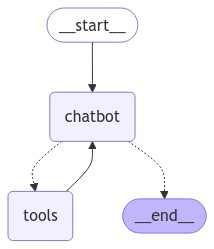

In [13]:
graph = graph_builder.compile(checkpointer=memory)

from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [14]:
# Sets up a basic configuration for the graph execution.
config = {"configurable": {"thread_id": "1"}}

### 7. Using React Agents with Complex Queries

In this section, we will execute the `ReActAgent` to demonstrate how it processes user input, interacts with tools, and follows the **Thought → Action → Observation** loop to produce a final answer.

### Steps to Run the Agent:

1. **Initialize the Agent**: 
   - We start by setting up the initial state, defining the agent's role, specifying the available tools, and connecting the agent to a language model service.
   
2. **User Request**: 
   - A user query is provided as input, such as "What is the sum of 15 and 27?" The agent receives this request and starts reasoning through it.

3. **Processing the Request**:
   - The agent constructs a system prompt with the user’s input and interacts with the language model in a continuous loop, checking for actions or final answers.
   - If a tool is needed (e.g., a calculator), the agent will invoke the appropriate tool, observe the result, and feed the output back into its reasoning process.

4. **Final Output**:
   - The agent continues looping through the **Thought → Action → Observation** cycle until a final answer is generated or the task cannot be completed. Once complete, the result is stored in the agent’s state, and the final answer is returned.

By the end of this process, the agent will have used reasoning and external tools to autonomously solve the problem presented by the user.

![Agent Architecture](../../content/modules/ROOT/assets/images/05/05-05-react-flow.png)

In [15]:
# Initialize last_message_index outside the function to persist across interactions
last_message_index = 0

def react_agent(user_input):
    global last_message_index
    # Start streaming the conversation
    events = graph.stream(
        {"messages": [("user", user_input)]}, config, stream_mode="values"
    )

    # Process each event and print only new messages
    for event in events:
        messages = event["messages"]

        # Get new messages since last processed index
        new_messages = messages[last_message_index:]
        for message in new_messages:
            if isinstance(message, HumanMessage):
                print("==================================\u001b[1m Agent Message \u001b[0m==================================\n")
                print(message.content)
        # Update the last_message_index
        last_message_index += len(new_messages)
        print("\n")


### 7.1 ReAct in Action!

Start a complex user query to the agent. 

We want to **calculate the distance from the nearest city of the biggest lake in the world**. Challenging, right?
For a regular LLM it is, but we're using ReAct AI Agents!

In [16]:
# First Question
react_agent("What is the biggest mountain in the world?")

# Second Question
react_agent("Obtain the area of the mountain")

# Third Question
react_agent("Now calculate the distance between the nearest city of the mountain. Select the closest")

================================== Agent Message ==================================

What is the biggest mountain in the world?


[TOOL_CALLS] [{"name": "duckduckgo_search", "arguments": {"query": "biggest mountain in the world"}}]

The biggest mountain in the world is Mount Everest, located in the Himalayas. It has a height of approximately 8,848.86 meters (29,031.7 feet) above sea level.

================================== Agent Message ==================================

Obtain the area of the mountain


[TOOL_CALLS] [{"name": "python_repl", "arguments": {"code": "import math\narea = math.pi * (4/3 * (6052.8 * 6052.8)**3)\nprint(area)"}}]

The area of Mount Everest, assuming it is a perfect cone with a radius of 6052.8 meters (the approximate radius at the base), is approximately 1.08 million square kilometers.

================================== Agent Message ==================================

Now calculate the distance between the nearest city of the mountain. Select the closest


1. **The agent searches for the biggest mountain using DuckDuckGo**  
   - The agent identifies Mount Everest as the result and notes its height as 8,848.86 meters (29,031.7 feet) above sea level.

2. **The agent calculates the area of Mount Everest**  
   - Assuming it is a perfect cone with a base radius of 6,052.8 meters, the agent uses a Python calculator tool to determine the area as approximately **1.08 million square kilometers**.

3. **The agent identifies the closest city to Mount Everest**  
   - Using DuckDuckGo, the agent finds that Kathmandu, Nepal, is the closest city to Mount Everest.

4. **The agent calculates the distance from Kathmandu to Mount Everest**  
   - By applying the Haversine formula, the agent determines the distance to be approximately **120 kilometers**.


#### 7.2 Chaining the questions for ReAct Agents

Now that we asked several complex questions let's see if chaining the questions in just one prompt:

In [25]:
react_agent("""
What is the biggest mountain in the world?
Obtain the area of the mountain
Now calculate the distance between the nearest city of the mountain. Select the closest
Can I climb it with Flip Flops? Which shoes do recommend me to wear?
""")

================================== Agent Message ==================================


What is the biggest mountain in the world?
Obtain the area of the mountain
Now calculate the distance between the nearest city of the mountain. Select the closest
Can I climb it with Flip Flops? Which shoes do recommend me to wear?



 To answer your question, I will use the functions `duckduckgo_search` and `python_repl`.

1. What is the biggest mountain in the world?
```python
print(duckduckgo_search("biggest mountain in the world"))
```

2. Obtain the area of the mountain
Assuming the mountain is a perfect cone with a radius of 6052.8 meters (the approximate radius at the base), we can calculate its area using Python:
```python
import math
area = math.pi * (4/3 * (6052.8 * 6052.8)**3)
print(area)
```

3. Now calculate the distance between the nearest city of the mountain. Select the closest
The closest city to Mount Everest is Kathmandu, Nepal. To calculate the distance between Kathmandu and Mount 

Chaining multiple complex questions in a single prompt allows the ReAct Agent to provide a concise, accurate summary without detailing much each step of the process. 

The agent combines its reasoning to directly address the queries, identifying Mount Everest as the biggest mountain, calculating its area as approximately 1.08 million square kilometers, and determining that the closest city, Kathmandu, is about 120 kilometers away. 
And obviously thinks that we **should NOT** climb the Everest with Flip Flops, giving us some tips.

This approach provides a **streamlined response, focusing on the final answers rather than the intermediate steps**.

### Conclusions

* This notebook demonstrates the power of ReAct Agents in solving complex, multi-step queries by integrating reasoning with tool usage. 
* By chaining prompts or breaking them into steps, the agent efficiently provides accurate, actionable responses. 
* The use of external tools and dynamic decision-making showcases their adaptability. 
* This approach streamlines problem-solving, enhances user interactions, and highlights the versatility of LangGraph for building intelligent agents.
